In [83]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
plt.style.use('fivethirtyeight')
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress
import pickle as pkl

from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn import preprocessing

In [44]:
files = glob.glob('../BL_Work/openPrescribe/savings/*.gz')

In [45]:
ome = pd.read_csv('scratchpad/ome_rossano.csv')

In [46]:
ome['BNF_stub'] = ome['bnf'].apply(lambda x: x[:-2])

In [47]:
ome.head()

,bnf_name,bnf,mg_per_unit,ome_multiplier,BNF_stub
0,Abstral_Tab Sublingual 100mcg,0407020A0BJAAAW,0.1,130.0,0407020A0BJAA
1,Abstral_Tab Sublingual 200mcg,0407020A0BJABAX,0.2,130.0,0407020A0BJAB
2,Abstral_Tab Sublingual 300mcg,0407020A0BJACAY,0.3,130.0,0407020A0BJAC
3,Abstral_Tab Sublingual 400mcg,0407020A0BJADAZ,0.4,130.0,0407020A0BJAD
4,Abstral_Tab Sublingual 600mcg,0407020A0BJAEBA,0.6,130.0,0407020A0BJAE


In [48]:
with open('scratchpad/Bipartite_Drug_graph.pkl','rb') as f:
    drug_association_graph  = pkl.load(f)

with open('scratchpad/Bipartite_Drug_category_graph.pkl','rb') as f:
    drug_cat_association_graph  = pkl.load(f)

In [49]:
files = glob.glob('../BL_Work/openPrescribe/savings/*.h5')
files.sort()
print files

['../BL_Work/openPrescribe/savings/201008.h5', '../BL_Work/openPrescribe/savings/201009.h5', '../BL_Work/openPrescribe/savings/201010.h5', '../BL_Work/openPrescribe/savings/201011.h5', '../BL_Work/openPrescribe/savings/201012.h5', '../BL_Work/openPrescribe/savings/201101.h5', '../BL_Work/openPrescribe/savings/201102.h5', '../BL_Work/openPrescribe/savings/201103.h5', '../BL_Work/openPrescribe/savings/201104.h5', '../BL_Work/openPrescribe/savings/201105.h5', '../BL_Work/openPrescribe/savings/201106.h5', '../BL_Work/openPrescribe/savings/201107.h5', '../BL_Work/openPrescribe/savings/201108.h5', '../BL_Work/openPrescribe/savings/201109.h5', '../BL_Work/openPrescribe/savings/201110.h5', '../BL_Work/openPrescribe/savings/201111.h5', '../BL_Work/openPrescribe/savings/201112.h5', '../BL_Work/openPrescribe/savings/201201.h5', '../BL_Work/openPrescribe/savings/201202.h5', '../BL_Work/openPrescribe/savings/201203.h5', '../BL_Work/openPrescribe/savings/201204.h5', '../BL_Work/openPrescribe/savings

In [50]:
files[65]

'../BL_Work/openPrescribe/savings/201601.h5'

In [51]:
pdp = pd.read_hdf(files[65])

In [52]:
pdp = pd.read_hdf(files[65])
pdp.dropna()
for file in files[66:66+3]:
    pdp2 = pd.read_hdf(file)
    pdp2.dropna()
    pdp.append(pdp2)

In [53]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 51135        59964  Q44  01R  N81084  0101010C0BBAAAA   
  55454        64283  Q44  01R  N81614  0101010C0AAAAAA   
  69323        78846  Q44  02D  N81087  0101010C0AAAAAA   
  81064        91133  Q44  02E  N81020  0101010C0AAAAAA   
  104971      115040  Q44  02E  N81122  0101010C0BBAAAA   

                                                 4    5      6      7      8  \
0 51135   Alu-Cap_Cap 475mg                         1.0  38.39  35.57  336.0   
  55454   Alum Hydrox_Cap 475mg                     1.0  13.71  12.66  120.0   
  69323   Alum Hydrox_Cap 475mg                     1.0  31.99  29.66  280.0   
  81064   Alum Hydrox_Cap 475mg                     2.0  25.60  23.86  224.0   
  104971  Alu-Cap_Cap 475mg                         1.0  19.19  17.84  168.0   

          ...                   14     15         16          17   18  \
0 51135   ...  Aluminium Hydroxide  475.0  0101010C0  112.000000  1.0   
  55454   ...  Aluminium Hydroxide  475.0  0101010C0   40.000000  1.0   
  69323   ...  Aluminium Hydroxide  475.0  0101010C0   93.333333  1.0   
  81064   ...  Aluminium Hydroxide  475.0  0101010C0   74.666667  1.0   
  104971  ...  Aluminium Hydroxide  475.0  0101010C0   56.000000  1.0   

                  19  20        21        22         23  
0 51135   112.000000  BB  0.110952  0.143333  10.880000  
  55454    40.000000  AA  0.110952  0.143333   3.885714  
  69323    93.333333  AA  0.110952  0.143333   9.066667  
  81064    74.666667  AA  0.110952  0.143333   7.253333  
  104971   56.000000  BB  0.110952  0.143333   5.440000  

[5 rows x 25 columns]

In [54]:
len(pdp)

9046629

In [55]:
bnf_ome_map_df = {'BNF' : [] , 'OME':[] , 'BNF_variants' : []}
for name , group in ome.groupby('BNF_stub'):
    bnf_ome_map_df['BNF'].append(name)
    bnf_ome_map_df['BNF_variants'].append(set(group['bnf_name']))
    bnf_ome_map_df['OME'].append(list(set(group['ome_multiplier']))[0])
bnf_ome_map_df = pd.DataFrame.from_dict(bnf_ome_map_df)

In [56]:
bnf_ome_map = {}
for name , group in ome.groupby('BNF_stub'):
#     if list(set(group['ome_multiplier']))[0] < 0:
    bnf_ome_map[name] = list(set(group['ome_multiplier']))[0]

In [57]:
bnf_ome_map_df.head()

,BNF,BNF_variants,OME
0,040702020AAAA,{Morph/Cyclizine_Inj 10mg/50mg 1ml Amp},2.0
1,040702020AAAB,{Morph/Cyclizine_Inj 15mg/50mg 1ml Amp},2.0
2,040702020BBAA,{Cyclimorph 10_Inj 1ml Amp},2.0
3,040702020BBAB,{Cyclimorph 15_Inj 1ml Amp},2.0
4,040702040AAAA,{Tramadol HCl_Cap 50mg},0.1


In [58]:
 bnf_ome_map_df[bnf_ome_map_df['OME'] > 10]

,BNF,BNF_variants,OME
129,0407020A0AAAE,{Fentanyl_Transdermal Patch 25mcg/hr},100.0
130,0407020A0AAAF,{Fentanyl_Transdermal Patch 50mcg/hr},100.0
131,0407020A0AAAG,{Fentanyl_Transdermal Patch 75mcg/hr},100.0
132,0407020A0AAAH,{Fentanyl_Transdermal Patch 100mcg/hr},100.0
133,0407020A0AAAI,{Fentanyl_Loz 200mcg},100.0
134,0407020A0AAAJ,{Fentanyl_Loz 400mcg},100.0
135,0407020A0AAAK,{Fentanyl_Loz 600mcg},100.0
136,0407020A0AAAL,{Fentanyl_Loz 800mcg},100.0
137,0407020A0AAAN,{Fentanyl_Loz 1.2mg},100.0
138,0407020A0AAAP,{Fentanyl_Loz 1.6mg},100.0


In [59]:
pdp['24'] = pdp['3'].apply(lambda x : x[:-2])

In [60]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 51135        59964  Q44  01R  N81084  0101010C0BBAAAA   
  55454        64283  Q44  01R  N81614  0101010C0AAAAAA   
  69323        78846  Q44  02D  N81087  0101010C0AAAAAA   
  81064        91133  Q44  02E  N81020  0101010C0AAAAAA   
  104971      115040  Q44  02E  N81122  0101010C0BBAAAA   

                                                 4    5      6      7      8  \
0 51135   Alu-Cap_Cap 475mg                         1.0  38.39  35.57  336.0   
  55454   Alum Hydrox_Cap 475mg                     1.0  13.71  12.66  120.0   
  69323   Alum Hydrox_Cap 475mg                     1.0  31.99  29.66  280.0   
  81064   Alum Hydrox_Cap 475mg                     2.0  25.60  23.86  224.0   
  104971  Alu-Cap_Cap 475mg                         1.0  19.19  17.84  168.0   

          ...     15         16          17   18          19  20        21  \
0 51135   ...  475.0  0101010C0  112.000000  1.0  112.000000  BB  0.110952   
  55454   ...  475.0  0101010C0   40.000000  1.0   40.000000  AA  0.110952   
  69323   ...  475.0  0101010C0   93.333333  1.0   93.333333  AA  0.110952   
  81064   ...  475.0  0101010C0   74.666667  1.0   74.666667  AA  0.110952   
  104971  ...  475.0  0101010C0   56.000000  1.0   56.000000  BB  0.110952   

                22         23             24  
0 51135   0.143333  10.880000  0101010C0BBAA  
  55454   0.143333   3.885714  0101010C0AAAA  
  69323   0.143333   9.066667  0101010C0AAAA  
  81064   0.143333   7.253333  0101010C0AAAA  
  104971  0.143333   5.440000  0101010C0BBAA  

[5 rows x 26 columns]

In [61]:
opioids_ome = pdp[pdp['24'].isin(ome['BNF_stub'])]

In [62]:
opioids_ome.head()

Unnamed: 0    0    1       2                3  \
494 168748       182864  Q44  12F  N85008  040702020BBABAB   
    1358838     1511460  Q48  01V  N84021  040702020BBAAAA   
    1696351     1883688  Q49  01H  A82037  040702020BBAAAA   
    2172098     2429047  Q51  02Q  C84008  040702020AAABAB   
    2212315     2473273  Q51  02X  C86022  040702020BBABAB   

                                                    4    5       6       7  \
494 168748   Cyclimorph 15_Inj 1ml Amp                 4.0  109.44  101.13   
    1358838  Cyclimorph 10_Inj 1ml Amp                 1.0   43.85   40.51   
    1696351  Cyclimorph 10_Inj 1ml Amp                 2.0   31.58   29.40   
    2172098  Morph/Cyclizine_Inj 15mg/50mg 1ml Amp     3.0    5.46    5.04   
    2212315  Cyclimorph 15_Inj 1ml Amp                 2.0   27.36   25.30   

                8  ...    15         16    17   18    19  20    21    22  \
494 168748   60.0  ...  15.0  040702020  60.0  1.5  90.0  BB  1.00  1.68   
    1358838  25.0  ...  10.0  040702020  25.0  1.0  25.0  BB  1.00  1.62   
    1696351  18.0  ...  10.0  040702020  18.0  1.0  18.0  BB  1.00  1.62   
    2172098   3.0  ...  50.0  040702020   3.0  5.0  15.0  AA  1.62  1.00   
    2212315  15.0  ...  15.0  040702020  15.0  1.5  22.5  BB  1.00  1.68   

                23             24  
494 168748   40.80  040702020BBAB  
    1358838  15.50  040702020BBAA  
    1696351  11.16  040702020BBAA  
    2172098   0.00  040702020AAAB  
    2212315  10.20  040702020BBAB  

[5 rows x 26 columns]

In [63]:
drug_identifiers = opioids_ome['24'].unique()

In [105]:
features = {'ome':[], 'mean_pills':[], 'sigma_pills':[],'mean_potency':[], 'sigma_potency' : [] , 'BNF':[] , 'mean_cost':[] ,'sigma_cost':[] , 'mean_dosage':[] , 'sigma_dosage':[] }
for name , group in opioids_ome.groupby('24'):
#     if bnf_ome_map[name] < 10:
    features['BNF'].append(name)
    features['mean_pills'].append(np.mean(group['8']))
    features['sigma_pills'].append(np.std(group['8']))
    features['mean_potency'].append(np.mean(group['15']))
#     features['min_potency'].append(np.min(group['15']))
#     features['max_potency'].append(np.max(group['15']))
    features['sigma_potency'].append(np.std(group['15']))
    features['mean_cost'].append(np.mean(group['7']))
    features['sigma_cost'].append(np.std(group['7']))
    features['mean_dosage'].append(np.mean(group['19']))
    features['sigma_dosage'].append(np.std(group['19']))
    features['ome'].append(bnf_ome_map[name])
features = pd.DataFrame.from_dict(features)

In [106]:
features = features[features['mean_potency']!=0]

In [107]:
features.head()

,BNF,mean_cost,mean_dosage,mean_pills,mean_potency,ome,sigma_cost,sigma_dosage,sigma_pills,sigma_potency
0,040702020AAAA,8.667778,26.666667,5.333333,50.0,2.0,4.889955,15.092309,3.018462,0.0
1,040702020AAAB,16.110000,47.500000,9.500000,50.0,2.0,11.070000,32.500000,6.500000,0.0
2,040702020BBAA,17.891000,11.000000,11.000000,10.0,2.0,22.330664,13.791302,13.791302,0.0
3,040702020BBAB,69.463448,61.758621,41.172414,15.0,2.0,119.063825,105.946035,70.630690,0.0
4,040702040AAAA,206.694329,6755.102452,6755.102452,50.0,0.1,184.692521,6033.661176,6033.661176,0.0


In [108]:
features[features['mean_potency'] == 0.0]

,BNF,mean_cost,mean_dosage,mean_pills,mean_potency,ome,sigma_cost,sigma_dosage,sigma_pills,sigma_potency


[Text(0,0.5,'mean_cost'),
 Text(0,1.5,'mean_dosage'),
 Text(0,2.5,'mean_pills'),
 Text(0,3.5,'mean_potency'),
 Text(0,4.5,'ome'),
 Text(0,5.5,'sigma_cost'),
 Text(0,6.5,'sigma_dosage'),
 Text(0,7.5,'sigma_pills'),
 Text(0,8.5,'sigma_potency')]

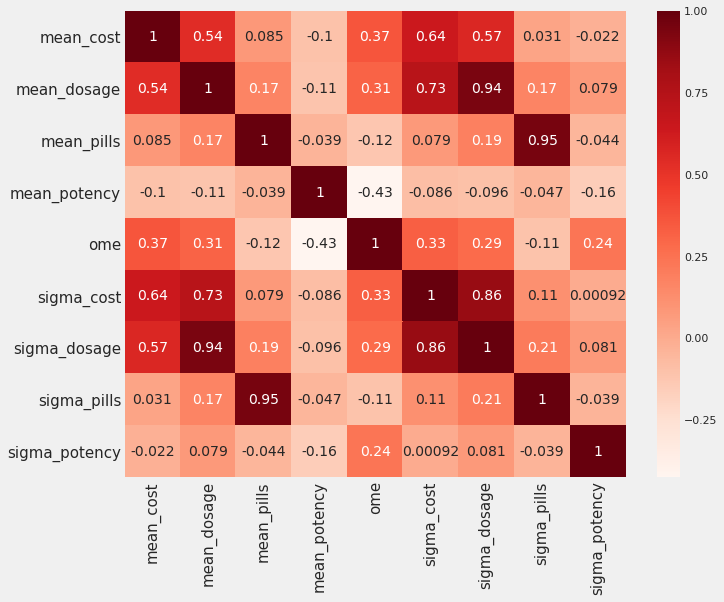

In [109]:
fig, ax = plt.subplots(figsize=(10,8))         
corr = features.corr(method='pearson')
sns.heatmap(corr, annot=True , ax=ax ,cmap='Reds' )
ax.set_xticklabels(corr.columns, fontsize=15)
ax.set_yticklabels(corr.columns, fontsize=15)

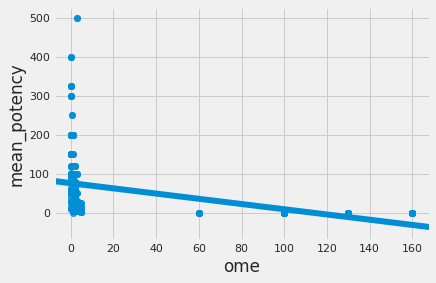

In [77]:
sns.regplot(features['ome'],features['mean_potency'])

Text(0.5,0,'ln(mean_dosage)')

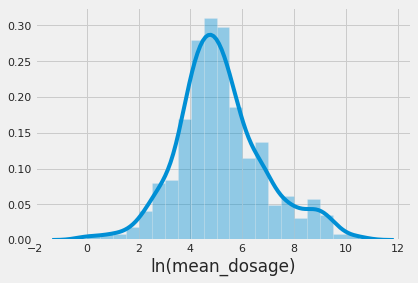

In [100]:
sns.distplot(np.log(features['mean_dosage']))
plt.xlabel("ln(mean_dosage)")

Text(0.5,0,'ln(mean_cost)')

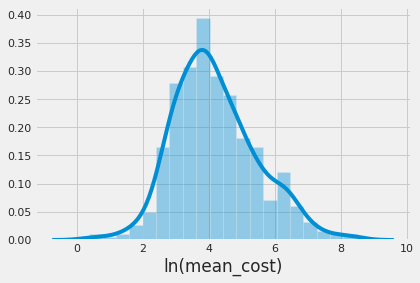

In [101]:
sns.distplot(np.log(features['mean_cost']))
plt.xlabel("ln(mean_cost)")

Text(0.5,0,'ln(mean_potecy)')

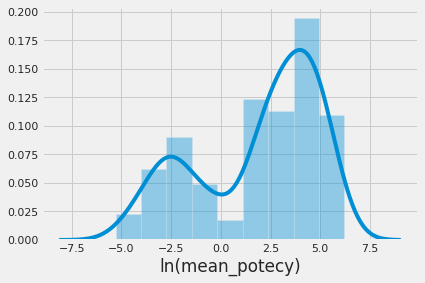

In [102]:
sns.distplot(np.log(features['mean_potency']))
plt.xlabel("ln(mean_potecy)")

Text(0.5,0,'ln(ome)')

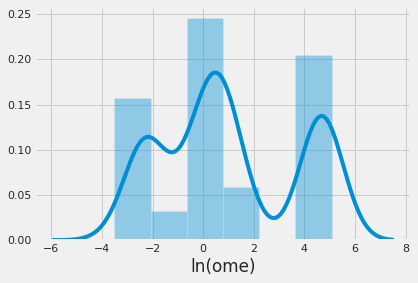

In [103]:
sns.distplot(np.log(features['ome']))
plt.xlabel("ln(ome)")

In [121]:
features['ln_mean_potency'] = np.log(features['mean_potency'])
features['ln_mean_dosage'] = np.log(features['mean_dosage'])
features['ln_mean_cost'] = np.log(features['mean_potency'])
features['ln_mean_pills'] = np.log(features['mean_pills'])
features['ln_Impact'] = np.log(features['mean_potency']/features['mean_pills'])

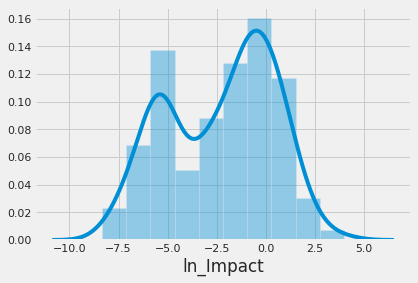

In [122]:
sns.distplot(features['ln_Impact'])

In [82]:
# features_to_normalize = ['ln_mean_potency','ln_mean_dosage','ln_mean_cost']
# features[features_to_normalize] = features[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [123]:
Y_dims = ['ome']
X_dims = ['ln_Impact']

In [124]:
min_max_scaler = preprocessing.MinMaxScaler() 
Y_ome = min_max_scaler.fit_transform(np.array(features[Y_dims].values,dtype=np.float32))
X_model = np.array(features[X_dims].values,dtype=np.float32)

In [125]:
X_model = sm.add_constant(X_model)
print(X_model)
model = sm.OLS(Y_ome, X_model).fit()
model.summary()

[[ 1.00000000e+00  2.23804665e+00]
 [ 1.00000000e+00  1.66073120e+00]
 [ 1.00000000e+00 -9.53101814e-02]
 [ 1.00000000e+00 -1.00971830e+00]
 [ 1.00000000e+00 -4.90603018e+00]
 [ 1.00000000e+00  5.36438227e-01]
 [ 1.00000000e+00 -9.42205489e-01]
 [ 1.00000000e+00  3.61542881e-01]
 [ 1.00000000e+00  3.79265189e-01]
 [ 1.00000000e+00 -1.13128805e+00]
 [ 1.00000000e+00 -1.32942414e+00]
 [ 1.00000000e+00 -9.12108541e-01]
 [ 1.00000000e+00  3.67391020e-01]
 [ 1.00000000e+00  3.02334815e-01]
 [ 1.00000000e+00  1.81971133e+00]
 [ 1.00000000e+00  2.28870082e+00]
 [ 1.00000000e+00  2.37157798e+00]
 [ 1.00000000e+00 -9.86820161e-01]
 [ 1.00000000e+00 -3.93067934e-02]
 [ 1.00000000e+00 -1.15821111e+00]
 [ 1.00000000e+00 -3.68887949e+00]
 [ 1.00000000e+00  9.26030338e-01]
 [ 1.00000000e+00  6.56967521e-01]
 [ 1.00000000e+00 -1.31404591e+00]
 [ 1.00000000e+00  1.51412773e+00]
 [ 1.00000000e+00 -1.66751772e-01]
 [ 1.00000000e+00  6.94725513e-01]
 [ 1.00000000e+00  9.23264802e-01]
 [ 1.00000000e+00 -1

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     697.3
Date:                Thu, 20 Aug 2020   Prob (F-statistic):           2.38e-93
Time:                        14:28:45   Log-Likelihood:                 86.900
No. Observations:                 450   AIC:                            -169.8
Df Residuals:                     448   BIC:                            -161.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.012     -0.289      0.773      -0.028       0.021
x1            -0.0919      0.003    -26.406      0.000      -0.099      -0.085
==============================================================================
Omnibus:                       34.112   Durbin-Watson:                   0.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.035
Skew:                           0.483   Prob(JB):                     5.58e-14
Kurtosis:                       4.524   Cond. No.                         4.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
predicted = model.predict(X_model)

Text(0,0.5,'normalized predicted ln(ome)')

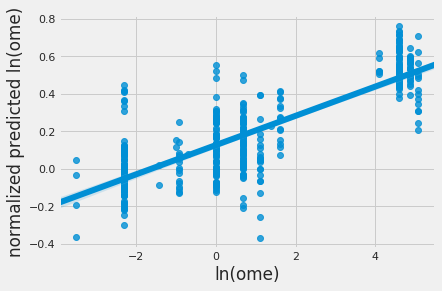

In [127]:
sns.regplot(np.log(features['ome']),predicted)
plt.xlabel('ln(ome)')
plt.ylabel('normalized predicted ln(ome)')